In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving reddit_label.csv to reddit_label.csv


In [3]:
reddit = pd.read_csv("reddit_label.csv")

In [4]:
reddit.head()

,Unnamed: 0,text,sentiment
0,0,number people coronavirus infection may dozen ...,positive
1,1,least 11 tested blood donor stockholm covid19 ...,negative
2,2,ending coronavirus lockdown will dangerous pro...,negative
3,3,nyc health 18 death new york city without unde...,positive
4,4,wearing mask protect coronavirus big mistake t...,positive


In [6]:
reindexed_data = reddit['text']

In [30]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=32648, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: fair enough finger crossed pass phase ii trial well excellent place
Headline after vectorization: 
  (0, 21612)	1
  (0, 21435)	1
  (0, 14882)	1
  (0, 28843)	1
  (0, 8367)	1
  (0, 11694)	1
  (0, 12104)	1
  (0, 21003)	1
  (0, 11332)	1


In [9]:
small_count_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
small_text_sample = reindexed_data.sample(n=30000, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: fair enough finger crossed pass phase ii trial well excellent place
Headline after vectorization: 
  (0, 10818)	0.35877539773740497
  (0, 20067)	0.40997170543390377
  (0, 11563)	0.35699290968659525
  (0, 11170)	0.304627472740566
  (0, 7991)	0.4050663129338198
  (0, 27582)	0.2325731718288834
  (0, 14219)	0.3655801911083139
  (0, 20473)	0.28174175347362557
  (0, 20644)	0.2275198674789668


In [10]:
n_topics = 10

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [11]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [12]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii', 'ignore').decode('ascii'))  #encode('ascii').decode('utf-8')
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
#@title
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

In [ ]:
#@title
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [13]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

In [70]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [19]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [20]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [21]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  use people patient its used oxygen lot city work subway
Topic 2:  comment rcovid19 factual source post study thank claim believe possible
Topic 3:  thank know discussion let believe personal rule rcovid19 keeping attack
Topic 4:  mask people dont work think make need virus know home
Topic 5:  virus vitamin cell blood immune antibody human people response level
Topic 6:  people know im virus year dont time day really thing
Topic 7:  people case death vaccine rate number population immunity infection virus
Topic 8:  patient risk study its disease people covid19 symptom effect infection
Topic 9:  test positive death week case false people new nyc tested
Topic 10:  people think time lockdown need good hospital point case thats


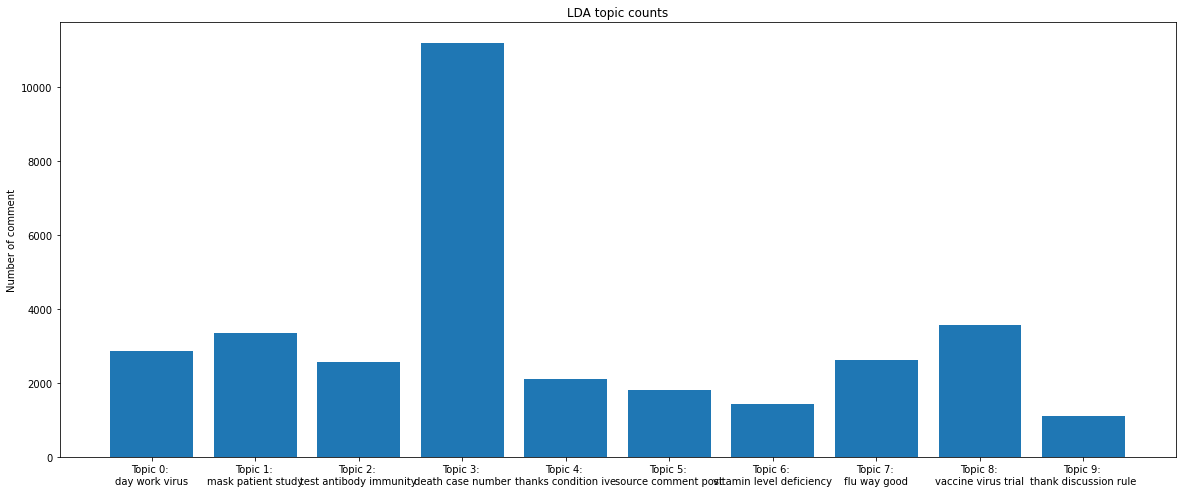

In [74]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of comment');

In [76]:
#tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        #n_iter=2000, verbose=1, random_state=0, angle=0.75)
#tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=50, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 32648 samples in 0.055s...
[t-SNE] Computed neighbors for 32648 samples in 10.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32648
[t-SNE] Computed conditional probabilities for sample 2000 / 32648
[t-SNE] Computed conditional probabilities for sample 3000 / 32648
[t-SNE] Computed conditional probabilities for sample 4000 / 32648
[t-SNE] Computed conditional probabilities for sample 5000 / 32648
[t-SNE] Computed conditional probabilities for sample 6000 / 32648
[t-SNE] Computed conditional probabilities for sample 7000 / 32648
[t-SNE] Computed conditional probabilities for sample 8000 / 32648
[t-SNE] Computed conditional probabilities for sample 9000 / 32648
[t-SNE] Computed conditional probabilities for sample 10000 / 32648
[t-SNE] Computed conditional probabilities for sample 11000 / 32648
[t-SNE] Computed conditional probabilities for sample 12000 / 32648
[t-SNE] Computed conditional probabilities for s

In [77]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

Only Noun

In [27]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [28]:
reindexed_data2 = reindexed_data.apply(nouns)
reindexed_data2

0           number people infection dozen time number case
1              blood donor stockholm covid19 antibody week
2                 coronavirus lockdown process trial error
3                         health death york city condition
4               mask protect coronavirus mistake scientist
                               ...                        
32644    course people line vaccine scenario heard peop...
32645                            death concern side effect
32646    source youre plan action vaccinating highrisk ...
32647                                        people reddit
32648    people symptom fatigue risk strokeheart attack...
Name: text, Length: 32649, dtype: object

In [32]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data2.sample(n=32648, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: finger pass phase ii trial place
Headline after vectorization: 
  (0, 11186)	1
  (0, 11081)	1
  (0, 7392)	1
  (0, 15447)	1
  (0, 5605)	1
  (0, 10806)	1


In [33]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [34]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [35]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  people virus mask immunity antibody vaccine time work im study
Topic 2:  people test home time week thing case work virus way
Topic 3:  virus people day question infection covid19 issue time city case
Topic 4:  people risk health dont patient life care time youre treatment
Topic 5:  people sub science coronavirus hospital economy state start lot dont
Topic 6:  comment vaccine thank trial source post thanks claim speculation research
Topic 7:  people death case number rate population infection study time test
Topic 8:  vitamin day level discussion rule people attack forum redditors respect
Topic 9:  article people air symptom difference virus taste thing guess day
Topic 10:  data study evidence people china doctor way help dont test


In [52]:
# Re-add the additional stop words since we are recreating the document-term matrix
from sklearn.feature_extraction import text 
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'im', 'thing', 'its']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [53]:
small_count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
small_text_sample = reindexed_data2.sample(n=32648, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: finger pass phase ii trial place
Headline after vectorization: 
  (0, 11181)	1
  (0, 11076)	1
  (0, 7390)	1
  (0, 15437)	1
  (0, 5604)	1
  (0, 10802)	1


In [54]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [55]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [56]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  virus immunity antibody infection risk year blood disease patient covid19
Topic 2:  study vaccine trial work vitamin drug data effect level group
Topic 3:  thanks virus symptom day week hand food store market taste
Topic 4:  mask day work virus home result hospital lot way week
Topic 5:  death case number rate population week infection day country data
Topic 6:  discussion rule attack respect forum promote redditors insult remark dialog
Topic 7:  source news advice its research sub post report comment health
Topic 8:  test article specificity doctor coronavirus antibody virus mean link result
Topic 9:  science day oxygen theyre guy look virus answer work dos
Topic 10:  use help medium team issue evidence rosetta work information phase


n+adj

In [57]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [58]:
reindexed_data3 = reindexed_data.apply(nouns_adj)

In [63]:
small_count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
small_text_sample = reindexed_data3.sample(n=32648, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: fair finger pass phase ii trial excellent place
Headline after vectorization: 
  (0, 15026)	1
  (0, 14883)	1
  (0, 9624)	1
  (0, 20552)	1
  (0, 6997)	1
  (0, 7317)	1
  (0, 14528)	1
  (0, 6732)	1


In [64]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [65]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [66]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  day work virus lot home week state mask different disease
Topic 2:  mask patient study use drug covid19 work hospital virus treatment
Topic 3:  test antibody immunity virus positive infection study false mean herd
Topic 4:  death case number rate population day infection data virus week
Topic 5:  thanks condition ive lung social virus issue air market high
Topic 6:  source comment post research news report medical advice original scientific
Topic 7:  vitamin level deficiency sun supplement year iu day ok study
Topic 8:  flu way good sub sure virus bad new year point
Topic 9:  vaccine virus trial immune blood work cell effect human antibody
Topic 10:  thank discussion rule essential personal attack rcovid19 respect redditors forum
